In [76]:
import pandas as pdx
import numpy as np

In [210]:
from datetime import datetime
import math
import numpy.linalg

def to_datetime(date_str):
    return datetime.strptime(date_str,'%Y-%m-%dT%H:%M:%SZ')

def robust_pca(M):
    """ 
    Decompose a matrix into low rank and sparse components.
    Computes the RPCA decomposition using Alternating Lagrangian Multipliers.
    Returns L,S the low rank and sparse components respectively
    """
    L = numpy.zeros(M.shape)
    S = numpy.zeros(M.shape)
    Y = numpy.zeros(M.shape)
    print(M.shape)
    mu = (M.shape[0] * M.shape[1]) / (4.0 * L1Norm(M))
    lamb = max(M.shape) ** -0.5
    while not converged(M,L,S):
        L = svd_shrink(M - S - (mu**-1) * Y, mu)
        S = shrink(M - L + (mu**-1) * Y, lamb * mu)
        Y = Y + mu * (M - L - S)
    return L,S
    
def svd_shrink(X, tau):
    """
    Apply the shrinkage operator to the singular values obtained from the SVD of X.
    The parameter tau is used as the scaling parameter to the shrink function.
    Returns the matrix obtained by computing U * shrink(s) * V where 
        U are the left singular vectors of X
        V are the right singular vectors of X
        s are the singular values as a diagonal matrix
    """
    U,s,V = numpy.linalg.svd(X, full_matrices=False)
    return numpy.dot(U, numpy.dot(numpy.diag(shrink(s, tau)), V))
    
def shrink(X, tau):
    """
    Apply the shrinkage operator the the elements of X.
    Returns V such that V[i,j] = max(abs(X[i,j]) - tau,0).
    """
    V = numpy.copy(X).reshape(X.size)
    for i in range(V.size):
        V[i] = math.copysign(max(abs(V[i]) - tau, 0), V[i])
        if V[i] == -0:
            V[i] = 0
    return V.reshape(X.shape)
            
def frobeniusNorm(X):
    """
    Evaluate the Frobenius norm of X
    Returns sqrt(sum_i sum_j X[i,j] ^ 2)
    """
    accum = 0
    V = numpy.reshape(X,X.size)
    for i in range(V.size):
        accum += abs(V[i] ** 2)
    return math.sqrt(accum)

def L1Norm(X):
    """
    Evaluate the L1 norm of X
    Returns the max over the sum of each column of X
    """
    return max(numpy.sum(X,axis=0))

def converged(M,L,S):
    """
    A simple test of convergence based on accuracy of matrix reconstruction
    from sparse and low rank parts
    """
    error = frobeniusNorm(M - L - S) / frobeniusNorm(M)
    print("error =", error)
    return error <= 10e-6

In [366]:
df = pd.read_csv('orders.csv')
print(df)
df["created_at"] = df["created_at"].map(lambda x: to_datetime(x))
df["hour"] = df["created_at"].map(lambda x: x.hour)
df["weekday"] = df["created_at"].map(lambda x: x.weekday())
df["month"] = df["created_at"].map(lambda x: x.month)
df["year"] = df["created_at"].map(lambda x: x.year)
df.head()

        order_id   store_id  to_user_distance  to_user_elevation  \
0       14364873   30000009          2.478101         -72.719360   
1       14370123   30000058          0.451711          37.754761   
2       14368534  900003684          2.026072         207.191162   
3       14370258  900014452          2.671432           1.722656   
4       14369923  900014085          0.965496         117.429199   
...          ...        ...               ...                ...   
146982  15650722  900005635          1.503389          86.380493   
146983  15651534  900005727          2.442553         289.788574   
146984  15651511  900010396          0.094488           0.094238   
146985  15651572   30000322          2.119052         183.751465   
146986  15652152   30000141          0.217849          -2.064209   

        total_earning            created_at  taken  
0                4200  2017-09-07T20:02:17Z      0  
1                4200  2017-09-07T20:13:16Z      0  
2                4000  2

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken,hour,weekday,month,year
0,14364873,30000009,2.478101,-72.719360,4200,2017-09-07 20:02:17,0,20,3,9,2017
1,14370123,30000058,0.451711,37.754761,4200,2017-09-07 20:13:16,0,20,3,9,2017
2,14368534,900003684,2.026072,207.191162,4000,2017-09-07 20:07:23,0,20,3,9,2017
3,14370258,900014452,2.671432,1.722656,4400,2017-09-07 20:15:19,1,20,3,9,2017
4,14369923,900014085,0.965496,117.429199,3450,2017-09-07 20:12:14,1,20,3,9,2017


In [81]:
datetime.now().month

11

In [85]:
df.describe()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,taken,hour,weekday,month,year
count,1.469870e+05,1.469870e+05,146987.000000,146987.000000,146987.000000,146987.000000,146987.000000,146987.000000,146987.000000,146987.0
mean,1.507718e+07,7.580708e+08,1.501015,26.899130,5358.641594,0.921218,15.759258,3.368624,9.124317,2017.0
std,4.750119e+05,3.214280e+08,0.845776,84.907724,1779.800955,0.269400,3.803290,2.031396,0.329944,0.0
min,1.421073e+07,3.000000e+07,0.000000,-598.296875,0.000000,0.000000,0.000000,0.000000,9.000000,2017.0
25%,1.466969e+07,9.000045e+08,0.836511,-18.348755,4200.000000,1.000000,13.000000,2.000000,9.000000,2017.0
50%,1.509241e+07,9.000077e+08,1.390230,11.145264,5200.000000,1.000000,16.000000,4.000000,9.000000,2017.0
75%,1.547355e+07,9.000127e+08,2.029955,61.024353,6300.000000,1.000000,19.000000,5.000000,9.000000,2017.0
max,1.590252e+07,9.000173e+08,9.360177,1009.380005,108200.000000,1.000000,23.000000,6.000000,10.000000,2017.0


In [208]:
df.corr()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,taken,hour,weekday,month,year
order_id,1.000000,-0.005426,0.051122,0.011867,0.197666,0.001114,0.007846,-0.004637,0.563583,NaN
store_id,-0.005426,1.000000,-0.042562,0.023414,-0.069755,-0.017427,0.057598,0.009064,-0.006616,NaN
to_user_distance,0.051122,-0.042562,1.000000,0.152468,0.237837,-0.087533,-0.001094,0.004168,0.013580,NaN
to_user_elevation,0.011867,0.023414,0.152468,1.000000,0.105381,0.009727,0.033329,0.060572,-0.000084,NaN
total_earning,0.197666,-0.069755,0.237837,0.105381,1.000000,0.041572,-0.017918,0.079944,0.033930,NaN
taken,0.001114,-0.017427,-0.087533,0.009727,0.041572,1.000000,-0.031585,0.016928,0.012598,NaN
hour,0.007846,0.057598,-0.001094,0.033329,-0.017918,-0.031585,1.000000,-0.012270,-0.032908,NaN
weekday,-0.004637,0.009064,0.004168,0.060572,0.079944,0.016928,-0.012270,1.000000,-0.048975,NaN
month,0.563583,-0.006616,0.013580,-0.000084,0.033930,0.012598,-0.032908,-0.048975,1.000000,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [214]:
M = df[['store_id','to_user_distance','to_user_elevation','total_earning','hour','weekday','month']].values
L,S = robust_pca(M)

(146987, 7)
error = 1.0
error = 1.845625931183821e-20


In [293]:
from sklearn.preprocessing import StandardScaler
z = StandardScaler()
S = z.fit_transform(S)
outliers1 = np.sum((S>2).T,axis=0)>=1
outliers2 = np.sum((S<-2).T,axis=0)>=1
outliers = outliers1 | outliers2
df_outliers = df.loc[outliers]
df_clean = df.loc[~outliers]

print(df_clean[df.taken == 0].shape)
print(df_outliers[df.taken == 0].shape)
print(df_clean[df.taken == 1].shape)
print(df_outliers[df.taken == 1].shape)

(8711, 11)
(2869, 11)
(102477, 11)
(32930, 11)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


## Preparando los datos

In [296]:
scaler = StandardScaler()


df_std = pd.DataFrame(
    scaler.fit_transform(df_clean[['store_id','to_user_distance','to_user_elevation','total_earning','hour','weekday','month']]),
    columns=['store_id','to_user_distance','to_user_elevation','total_earning','hour','weekday','month'],
        index=df_clean.index
)
df_training = pd.concat([df_std,df_clean['taken']],axis=1)
df_training

,store_id,to_user_distance,to_user_elevation,total_earning,hour,weekday,month,taken
2,0.020249,0.901928,2.188513,-0.735528,1.097416,-0.184738,-0.374312,0
3,0.026712,1.803497,-0.334004,-0.501354,1.097416,-0.184738,-0.374312,1
4,0.026492,-0.579700,1.086514,-1.057518,1.097416,-0.184738,-0.374312,1
5,0.020657,-1.122213,-0.452089,-0.033005,1.097416,-0.184738,-0.374312,1
6,0.022164,1.645088,-0.304987,-0.618441,1.097416,-0.184738,-0.374312,0
...,...,...,...,...,...,...,...,...
146979,0.020811,-0.188498,-0.592631,-1.203877,0.032910,0.798798,-0.374312,1
146980,0.024469,-0.049374,0.046861,-1.203877,0.032910,0.798798,-0.374312,1
146982,0.021420,0.171738,0.705332,0.640247,0.032910,0.798798,-0.374312,1
146983,0.021475,1.483754,3.202553,-0.472082,0.032910,0.798798,-0.374312,1


In [342]:
X0 = df_training[df_training.taken == 0]
X1 = df_training[df_training.taken == 1]
print(X0.shape)
print(X1.shape)
to_feature_selection = pd.concat((X1,X0), axis=0)
to_feature_selection.to_csv('to_feature_selection.csv')
X1.shape[0]-8711*11

(8711, 8)
(102477, 8)


6656

In [343]:
dfs = np.split(df_training, [8711,8711*2,8711*3,8711*4,8711*5,8711*6,8711*7,8711*8,
                             8711*9,8711*10,8711*11,8711*11+8027], axis=0)
for df_o in dfs:
    print(len(df_o))

8711
8711
8711
8711
8711
8711
8711
8711
8711
8711
8711
8027
7340


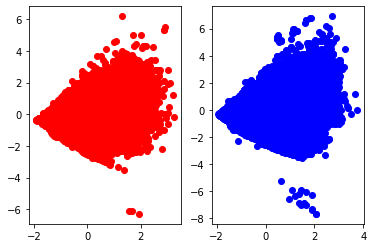

In [344]:
from matplotlib import pyplot as plt
plt.subplot(1,2,1)
plt.plot(X0.to_user_distance, X0.to_user_elevation, 'ro')
plt.subplot(1,2,2)
plt.plot(X1.to_user_distance, X1.to_user_elevation, 'bo')

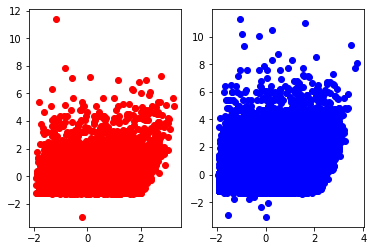

In [345]:
plt.subplot(1,2,1)
plt.plot(X0.to_user_distance, X0.total_earning, 'ro')
plt.subplot(1,2,2)
plt.plot(X1.to_user_distance, X1.total_earning, 'bo')

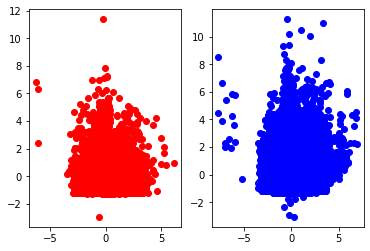

In [346]:
plt.subplot(1,2,1)
plt.plot(X0.to_user_elevation, X0.total_earning, 'ro')
plt.subplot(1,2,2)
plt.plot(X1.to_user_elevation, X1.total_earning, 'bo')

# Probando los modelos

In [350]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit

for df_o in dfs:
    
    dataset1_train= X0.sample(n = int(X0.shape[0]*0.7))
    X_train1 = dataset1_train[['store_id', 'to_user_distance', 'to_user_elevation', 'total_earning',
           'hour', 'weekday', 'month']]
    y_train1 = dataset1_train['taken']
    dataset1_test = X0.loc[~X0.index.isin(dataset1_train.index)]
    X_test1 = dataset1_test[['store_id', 'to_user_distance', 'to_user_elevation', 'total_earning',
           'hour', 'weekday', 'month']]
    y_test1 = dataset1_test['taken'];

    X1 = df_o;
    dataset2_train = X1.sample(n = int(X1.shape[0]*0.7))
    X_train2 = dataset2_train[['store_id', 'to_user_distance', 'to_user_elevation', 'total_earning',
           'hour', 'weekday', 'month']]
    y_train2 = dataset2_train['taken']
    dataset2_test = X1.loc[~X1.index.isin(dataset2_train.index)]
    X_test2 = dataset2_test[['store_id', 'to_user_distance', 'to_user_elevation', 'total_earning',
           'hour', 'weekday', 'month']]
    y_test2 = dataset2_test['taken'];

    X_train = pd.concat([X_train1,X_train2], axis=0)
    y_train = pd.concat([y_train1,y_train2], axis=0)

    X_test = pd.concat([X_test1,X_test2], axis=0)
    y_test = pd.concat([y_test1,y_test2], axis=0)

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

    mod1 = RandomForestClassifier(
                        n_estimators = 100,
                        random_state = 0,
                        bootstrap    = True
                      )
    NN = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
    log = LogisticRegression(random_state=0,solver='lbfgs')
    mod_svm = svm.SVC(kernel='rbf',probability=True)
    desicion_tree = tree.DecisionTreeClassifier()
    gbt = GradientBoostingClassifier(random_state=0)
    gnb = GaussianNB()
    knn = KNeighborsClassifier(n_neighbors=3)

    cv = ShuffleSplit(
                    n_splits     = 4,
                    test_size    = 0.3,
                    random_state = 0
                 )

    metrica_ran = cross_val_score(
                    estimator = mod1,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv,
                    scoring   = 'accuracy',
                    n_jobs    = 1
                 )
    metrica_log = cross_val_score(
                    estimator = log,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv,
                    scoring   = 'accuracy',
                    n_jobs    = 1
                 )
    metrica_svm = cross_val_score(
                    estimator = mod_svm,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv,
                    scoring   = 'accuracy',
                    n_jobs    = 1
                 )

    metrica_dt = cross_val_score(
                    estimator = desicion_tree,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv,
                    scoring   = 'accuracy',
                    n_jobs    = 1
                 )

    metrica_gbt = cross_val_score(
                    estimator = gbt,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv,
                    scoring   = 'accuracy',
                    n_jobs    = 1
                 )

    metrica_gnb = cross_val_score(
                    estimator = gnb,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv,
                    scoring   = 'accuracy',
                    n_jobs    = 1
                 )

    metrica_NN = cross_val_score(
                    estimator = NN,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv,
                    scoring   = 'accuracy',
                    n_jobs    = 1
                 )

    met_knn = cross_val_score(
                    estimator = knn,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv,
                    scoring   = 'accuracy',
                    n_jobs    = 1
                 )
    
    modelo = mod1.fit(X_train,y_train)
    modelo2 = gbt.fit(X_train,y_train)
    modelo4 = desicion_tree.fit(X_train,y_train)
    modelo5 = mod_svm.fit(X_train,y_train)
    modelo6 = log.fit(X_train,y_train)
    modelo7 = knn.fit(X_train,y_train)
    
    print('RandomForest: ',np.mean(metrica_ran))
    print('LogisticRegression: ',np.mean(metrica_log))
    print('SVM: ',np.mean(metrica_svm))
    print('DesicionTree: ',np.mean(metrica_dt))
    print('GradientBoostingTree: ',np.mean(metrica_gbt))
    print('knn: ',np.mean(met_knn))
    print('---------------------------TEST DATA---------------------------------')
    print('RandomForest: ',modelo.score(X_test,y_test))
    print('LogisticRegression: ',modelo2.score(X_test,y_test))
    print('SVM: ',modelo4.score(X_test,y_test))
    print('DesicionTree: ',modelo5.score(X_test,y_test))
    print('GradientBoostingTree: ',modelo6.score(X_test,y_test))
    print('knn: ',modelo7.score(X_test,y_test))
    print('-----------------------------------------------------------')

(12194, 7) (12194,)
(5228, 7) (5228,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

RandomForest:  0.6661656190215905
LogisticRegression:  0.5933998360207706
SVM:  0.6194315386717683
DesicionTree:  0.5967477452855972
GradientBoostingTree:  0.6645258267286145
knn:  0.6054249795025963
---------------------------TEST DATA---------------------------------
RandomForest:  0.6769319051262433
LogisticRegression:  0.6769319051262433
SVM:  0.6149579188982403
DesicionTree:  0.6333205814843152
GradientBoostingTree:  0.6021423106350421
knn:  0.6210788064269319
-----------------------------------------------------------
(12194, 7) (12194,)
(5228, 7) (5228,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

RandomForest:  0.6637742552610002
LogisticRegression:  0.5914184203334245
SVM:  0.6266739546324132
DesicionTree:  0.5943563815250068
GradientBoostingTree:  0.6634326318666303
knn:  0.6158786553703198
---------------------------TEST DATA---------------------------------
RandomForest:  0.6882172915072685
LogisticRegression:  0.6719586840091814
SVM:  0.6117061973986228
DesicionTree:  0.6289211935730681
GradientBoostingTree:  0.5872226472838562
knn:  0.606159143075746
-----------------------------------------------------------
(12194, 7) (12194,)
(5228, 7) (5228,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

RandomForest:  0.6630910084722601
LogisticRegression:  0.5970210440010932
SVM:  0.6291336430718776
DesicionTree:  0.5954495763869909
GradientBoostingTree:  0.6658923203060946
knn:  0.5992757584039355
---------------------------TEST DATA---------------------------------
RandomForest:  0.678079571537873
LogisticRegression:  0.6690895179801071
SVM:  0.6063504208110176
DesicionTree:  0.6258607498087223
GradientBoostingTree:  0.590283091048202
knn:  0.609602142310635
-----------------------------------------------------------
(12194, 7) (12194,)
(5228, 7) (5228,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

RandomForest:  0.6629543591145122
LogisticRegression:  0.5922383164799125
SVM:  0.6348045914184204
DesicionTree:  0.5945613555616288
GradientBoostingTree:  0.6648674501229843
knn:  0.5949713036348729
---------------------------TEST DATA---------------------------------
RandomForest:  0.6750191277735271
LogisticRegression:  0.6790359602142311
SVM:  0.6025248661055853
DesicionTree:  0.6470925784238715
GradientBoostingTree:  0.6034812547819434
knn:  0.6006120887528692
-----------------------------------------------------------
(12194, 7) (12194,)
(5228, 7) (5228,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

RandomForest:  0.6704017491117793
LogisticRegression:  0.5918283684066685
SVM:  0.6305001366493578
DesicionTree:  0.5954495763869909
GradientBoostingTree:  0.6749795025963379
knn:  0.6077480185843126
---------------------------TEST DATA---------------------------------
RandomForest:  0.6769319051262433
LogisticRegression:  0.6719586840091814
SVM:  0.6040550879877582
DesicionTree:  0.6367635807192042
GradientBoostingTree:  0.5975516449885233
knn:  0.618018362662586
-----------------------------------------------------------
(12194, 7) (12194,)
(5228, 7) (5228,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

RandomForest:  0.6725881388357475
LogisticRegression:  0.5971576933588413
SVM:  0.6266739546324132
DesicionTree:  0.5937414594151409
GradientBoostingTree:  0.6676004372779448
knn:  0.6079529926209347
---------------------------TEST DATA---------------------------------
RandomForest:  0.6763580719204285
LogisticRegression:  0.6696633511859219
SVM:  0.6107498087222647
DesicionTree:  0.6159143075745983
GradientBoostingTree:  0.5860749808722264
knn:  0.6138102524866106
-----------------------------------------------------------
(12194, 7) (12194,)
(5228, 7) (5228,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

RandomForest:  0.6804454769062585
LogisticRegression:  0.6005056026236677
SVM:  0.6369226564635146
DesicionTree:  0.6092511615195408
GradientBoostingTree:  0.6729297622301176
knn:  0.6103443563815251
---------------------------TEST DATA---------------------------------
RandomForest:  0.6910864575363428
LogisticRegression:  0.6853481254781943
SVM:  0.612088752869166
DesicionTree:  0.6503442999234889
GradientBoostingTree:  0.5977429227237949
knn:  0.6126625860749809
-----------------------------------------------------------
(12194, 7) (12194,)
(5228, 7) (5228,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

RandomForest:  0.669581852965291
LogisticRegression:  0.5992074337250615
SVM:  0.6290653183930035
DesicionTree:  0.5854741732713856
GradientBoostingTree:  0.6747745285597158
knn:  0.6012571740912818
---------------------------TEST DATA---------------------------------
RandomForest:  0.6798010711553175
LogisticRegression:  0.6629686304514154
SVM:  0.5954475899005356
DesicionTree:  0.6258607498087223
GradientBoostingTree:  0.5860749808722264
knn:  0.6069242540168325
-----------------------------------------------------------
(12194, 7) (12194,)
(5228, 7) (5228,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

RandomForest:  0.6719732167258815
LogisticRegression:  0.5967477452855972
SVM:  0.6341896693085542
DesicionTree:  0.6015304728067777
GradientBoostingTree:  0.6757310740639518
knn:  0.6022820442743919
---------------------------TEST DATA---------------------------------
RandomForest:  0.6669854628921194
LogisticRegression:  0.663733741392502
SVM:  0.595256312165264
DesicionTree:  0.6243305279265493
GradientBoostingTree:  0.5856924254016832
knn:  0.6107498087222647
-----------------------------------------------------------
(12194, 7) (12194,)
(5228, 7) (5228,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

RandomForest:  0.6758677234217
LogisticRegression:  0.5856791473080076
SVM:  0.6337797212353102
DesicionTree:  0.5988658103306914
GradientBoostingTree:  0.6715632686526374
knn:  0.6122574473899972
---------------------------TEST DATA---------------------------------
RandomForest:  0.6759755164498852
LogisticRegression:  0.6742540168324407
SVM:  0.6078806426931905
DesicionTree:  0.6287299158377965
GradientBoostingTree:  0.6004208110175976
knn:  0.6044376434583014
-----------------------------------------------------------
(12194, 7) (12194,)
(5228, 7) (5228,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

RandomForest:  0.6675321125990707
LogisticRegression:  0.5933315113418967
SVM:  0.6233943700464608
DesicionTree:  0.5940147581306368
GradientBoostingTree:  0.6747745285597158
knn:  0.6056982782180923
---------------------------TEST DATA---------------------------------
RandomForest:  0.6727237949502678
LogisticRegression:  0.6650726855394032
SVM:  0.6015684774292273
DesicionTree:  0.6294950267788829
GradientBoostingTree:  0.5977429227237949
knn:  0.6034812547819434
-----------------------------------------------------------
(11715, 7) (11715,)
(5023, 7) (5023,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

RandomForest:  0.6768847795163584
LogisticRegression:  0.6083926031294452
SVM:  0.6448790896159318
DesicionTree:  0.6046941678520625
GradientBoostingTree:  0.6753200568990043
knn:  0.6140113798008535
---------------------------TEST DATA---------------------------------
RandomForest:  0.6742982281505077
LogisticRegression:  0.6641449333067888
SVM:  0.617360143340633
DesicionTree:  0.6287079434600836
GradientBoostingTree:  0.5968544694405734
knn:  0.6183555644037427
-----------------------------------------------------------
(11235, 7) (11235,)
(4816, 7) (4816,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

RandomForest:  0.6667902699495698
LogisticRegression:  0.5998220112726195
SVM:  0.63119252447345
DesicionTree:  0.5889202017205577
GradientBoostingTree:  0.6779887273805992
knn:  0.6029368140017799
---------------------------TEST DATA---------------------------------
RandomForest:  0.6833471760797342
LogisticRegression:  0.6852159468438538
SVM:  0.6015365448504983
DesicionTree:  0.6411960132890365
GradientBoostingTree:  0.6098421926910299
knn:  0.6154485049833887
-----------------------------------------------------------


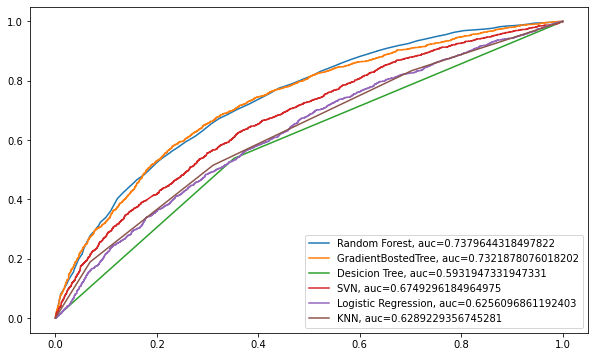

In [352]:
y_pred_proba = modelo.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

y_pred_proba2 = modelo2.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba2)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba2)

y_pred_proba4 = modelo4.predict_proba(X_test)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(y_test,  y_pred_proba4)
auc4 = metrics.roc_auc_score(y_test, y_pred_proba4)

y_pred_proba5 = modelo5.predict_proba(X_test)[::,1]
fpr5, tpr5, _ = metrics.roc_curve(y_test,  y_pred_proba5)
auc5 = metrics.roc_auc_score(y_test, y_pred_proba5)

y_pred_proba6 = modelo6.predict_proba(X_test)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(y_test,  y_pred_proba6)
auc6 = metrics.roc_auc_score(y_test, y_pred_proba6)

y_pred_proba7 = modelo7.predict_proba(X_test)[::,1]
fpr7, tpr7, _ = metrics.roc_curve(y_test,  y_pred_proba7)
auc7 = metrics.roc_auc_score(y_test, y_pred_proba7)

plt.figure(figsize=(10,6))

plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))
plt.plot(fpr2,tpr2,label="GradientBostedTree, auc="+str(auc2))
plt.plot(fpr4,tpr4,label="Desicion Tree, auc="+str(auc4))
plt.plot(fpr5,tpr5,label="SVN, auc="+str(auc5))
plt.plot(fpr6,tpr6,label="Logistic Regression, auc="+str(auc6))
plt.plot(fpr7,tpr7,label="KNN, auc="+str(auc7))

plt.legend(loc=4)
plt.show()

In [362]:
import pickle
model_file = 'rforest.sav'
pickle.dump(modelo, open(model_file, 'wb'))
scaler_file = 'scaler.sav'
pickle.dump(scaler, open(scaler_file, 'wb'))

In [365]:
loaded_model = pickle.load(open(filename2, 'rb'))
loaded_model.inverse_transform(X_test)

array([ 9.00005637e+08,  1.08326473e+00, -6.88414307e+01,  3.20000000e+03,
        2.00000000e+01,  3.00000000e+00,  9.00000000e+00])

[[2188  587]
 [ 938 1103]]


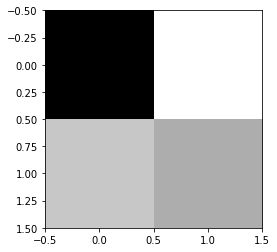

In [373]:
from sklearn.metrics import confusion_matrix
y_pred = modelo.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap='binary')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


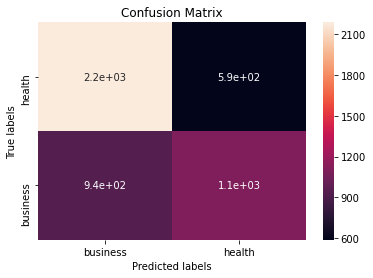

In [374]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);